## Imports

In [13]:
# Import libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt
import numpy as np

## Data Organization

### Pull relevant data

In [14]:
# Get the medal details dataset
df_medal_details = pd.read_csv('../data/etl/medals_by_season_country_discip_event_type.csv')
df_medal_details.head()

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1


In [15]:
# Get all of the other datasets in the etl folder
df_hapiness = pd.read_csv('../data/etl/happiness_avg_by_country.csv')
df_gdp = pd.read_csv('../data/etl/gdp_avg_by_country.csv')
df_nutrition = pd.read_csv('../data/etl/nutrition_2017_by_country.csv')
df_nutrition.head()

,country_code,country_name,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
0,ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.361
1,AGO,Angola,57.2,87.1,7.1,92.9,17.0,26.0,27.7,29816.769
2,AIA,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Albania,0.0,13.0,62.2,37.8,0.0,0.4,1.1,2873.457
4,ARE,United Arab Emirates,0.0,0.0,NaN,0.0,0.0,0.0,0.0,9487.206


### Clean it up

In [16]:
# Unwanted columns - Simplify the dataset
unwanted_cols = [
    'support',
    'health',
    'freedom',
    'generosity',
    'corruption',
    'positivity',
    'negativity',
    'calories_pct',
    'nutrients_pct',
    'calories_mills',
    'nutrients_mills',
    'diet_mills'
]

In [17]:
# Function to merge medals with happiness, GDP and nutrition datasets
def merge_hap_gdp_nut(df_medal_slice: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(df_medal_slice, df_hapiness, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_gdp, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_nutrition, on='country_name', how='left')
    df_merged = df_merged.drop(columns=['country_code']).reset_index(drop=True)
    df_merged.drop(unwanted_cols, axis=1, inplace=True)
    return df_merged

In [18]:
# Function to slice the medal details dataset and prepare it for correlation
def slice_medal_details_data(data_to_select: dict[str, str]) -> pd.DataFrame:
    drop_medal_cols = ['game_season', 'country_code', 'discipline_title', 'event_title', 'event_gender', 'medal_type']
    group_medal_cols = ['country_name']

    df_slice = df_medal_details.copy()
    for key, value in data_to_select.items():
        df_slice = df_slice[df_slice[key] == value]

    df_slice = df_slice.drop(columns=drop_medal_cols)
    df_slice = df_slice.groupby(group_medal_cols)['medal_count'].sum().reset_index()
    return df_slice.reset_index(drop=True)

### Stylize it

In [23]:
# Function to call heatmap "heatmap_medals"
def heatmap_medals(df: pd.DataFrame, title: str) -> None:
    medals = df['medal_count']
    ax = sns.heatmap()
    ax.set_xlabel(title)
    ax.set_ylabel(title)

In [24]:
# Function to update heatmap style "update_heatmap_labels"
def update_heatmap_labels(ax, new_col_labels, new_row_labels):
    ax.set_xticks(np.arange(len(new_col_labels)) + 0.5)
    ax.set_yticks(np.arange(len(new_row_labels)) + 0.5)
    ax.set_xticklabels(new_col_labels, rotation=30, ha='right')
    ax.set_yticklabels(new_row_labels, rotation=0)

# Summer Data

### Women's Summer

In [33]:
# Women's summer games correlation, collect info nd check dataframe
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   103 non-null    object 
 1   medal_count    103 non-null    int64  
 2   happiness      85 non-null     float64
 3   wealth         84 non-null     float64
 4   gdp_avg        84 non-null     float64
 5   good_diet_pct  69 non-null     float64
 6   bad_diet_pct   72 non-null     float64
 7   population     76 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 6.6+ KB


In [34]:
# Set index to country_name and compare correlations
df.set_index('country_name').corr()

,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.234169,0.292613,0.831738,0.287825,-0.269807,0.313934
happiness,0.234169,1.000000,0.802930,0.208903,0.745038,-0.729592,-0.178541
wealth,0.292613,0.802930,1.000000,0.228058,0.897316,-0.890775,-0.159272
gdp_avg,0.831738,0.208903,0.228058,1.000000,0.210865,-0.197154,0.409605
good_diet_pct,0.287825,0.745038,0.897316,0.210865,1.000000,-1.000000,-0.151061
bad_diet_pct,-0.269807,-0.729592,-0.890775,-0.197154,-1.000000,1.000000,0.159740
population,0.313934,-0.178541,-0.159272,0.409605,-0.151061,0.159740,1.000000


In [43]:
# Top and Bottom Womens Summer Games
# Reset index and sort values
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df_women_summer.head())
display(df_women_summer.tail())

,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,712,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,473,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,451,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,356,5.160455,9.340597,3291242.38,85.7,14.3,1396215.000
4,216,7.242307,10.764977,521918.13,99.3,0.7,24601.860


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
98,1,6.357284,10.051550,94857.75,96.6,3.4,18470.435
99,1,4.263359,9.297134,25338.77,47.7,52.3,21444.000
100,1,4.875571,9.590507,NaN,NaN,NaN,NaN
101,1,5.601965,9.313264,102416.78,76.3,23.7,31444.299
102,1,5.569637,10.204665,23121.80,96.6,3.4,1942.248


In [48]:
new_col_labels = ['Medal Count', 'Happiness', 'GDP per Capita', 'Good Diet %', 'Bad Diet %']
new_row_labels = df_women_summer.index.tolist()

df_women_summer.rename(columns={
    'medal_count': 'Medals Won',
    'happiness': 'Happiness',
    'gdp_avg': 'GDP per Capita',
    'good_diet_pct': 'Good Diet %',
    'bad_diet_pct': 'Bad Diet %',
    'population': 'Population'
}, inplace=True)

df_women_summer.head(10)

,Medals Won,Happiness,wealth,GDP per Capita,Good Diet %,Bad Diet %,Population
0,712,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,473,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,451,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,356,5.160455,9.340597,3291242.38,85.7,14.3,1396215.000
4,216,7.242307,10.764977,521918.13,99.3,0.7,24601.860
5,203,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
6,154,5.770220,10.115109,126545.07,88.1,11.9,19588.715
7,144,7.440393,10.897109,411682.28,99.6,0.4,17131.296
8,139,6.023527,10.593319,2938993.71,97.5,2.5,126785.797
9,124,7.296854,10.756211,755211.83,99.3,0.7,36545.295


In [44]:
df.set_index('country_name', inplace=True)
df_country_compare_women_summer = df.astype(float)
df_country_compare_women_summer

KeyError: "None of ['country_name'] are in the columns"

,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,712,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,473,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,451,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,356,5.160455,9.340597,3291242.38,85.7,14.3,1396215.000
4,216,7.242307,10.764977,521918.13,99.3,0.7,24601.860


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
98,1,6.357284,10.051550,94857.75,96.6,3.4,18470.435
99,1,4.263359,9.297134,25338.77,47.7,52.3,21444.000
100,1,4.875571,9.590507,NaN,NaN,NaN,NaN
101,1,5.601965,9.313264,102416.78,76.3,23.7,31444.299
102,1,5.569637,10.204665,23121.80,96.6,3.4,1942.248


In [45]:
sum_women_fig = heatmap_medals(df_country_compare_women_summer, 'Women\'s Summer Games')update_heatmap_labels(ax, new_col_labels, new_row_labels)

SyntaxError: invalid syntax (2662310183.py, line 1)

In [30]:
# Set index to country_name and adjust for floats
df.set_index('country_name', inplace=True)
df_country_compare_women_summer = df.astype(float)
df_country_compare_women_summer

KeyError: "None of ['country_name'] are in the columns"

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,712,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Russia,473,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,Germany,451,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,China,356,5.160455,9.340597,3291242.38,85.7,14.3,1396215.000
4,Australia,216,7.242307,10.764977,521918.13,99.3,0.7,24601.860


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
98,Chile,1,6.357284,10.051550,94857.75,96.6,3.4,18470.435
99,Sri Lanka,1,4.263359,9.297134,25338.77,47.7,52.3,21444.000
100,Iran,1,4.875571,9.590507,NaN,NaN,NaN,NaN
101,Peru,1,5.601965,9.313264,102416.78,76.3,23.7,31444.299
102,Latvia,1,5.569637,10.204665,23121.80,96.6,3.4,1942.248


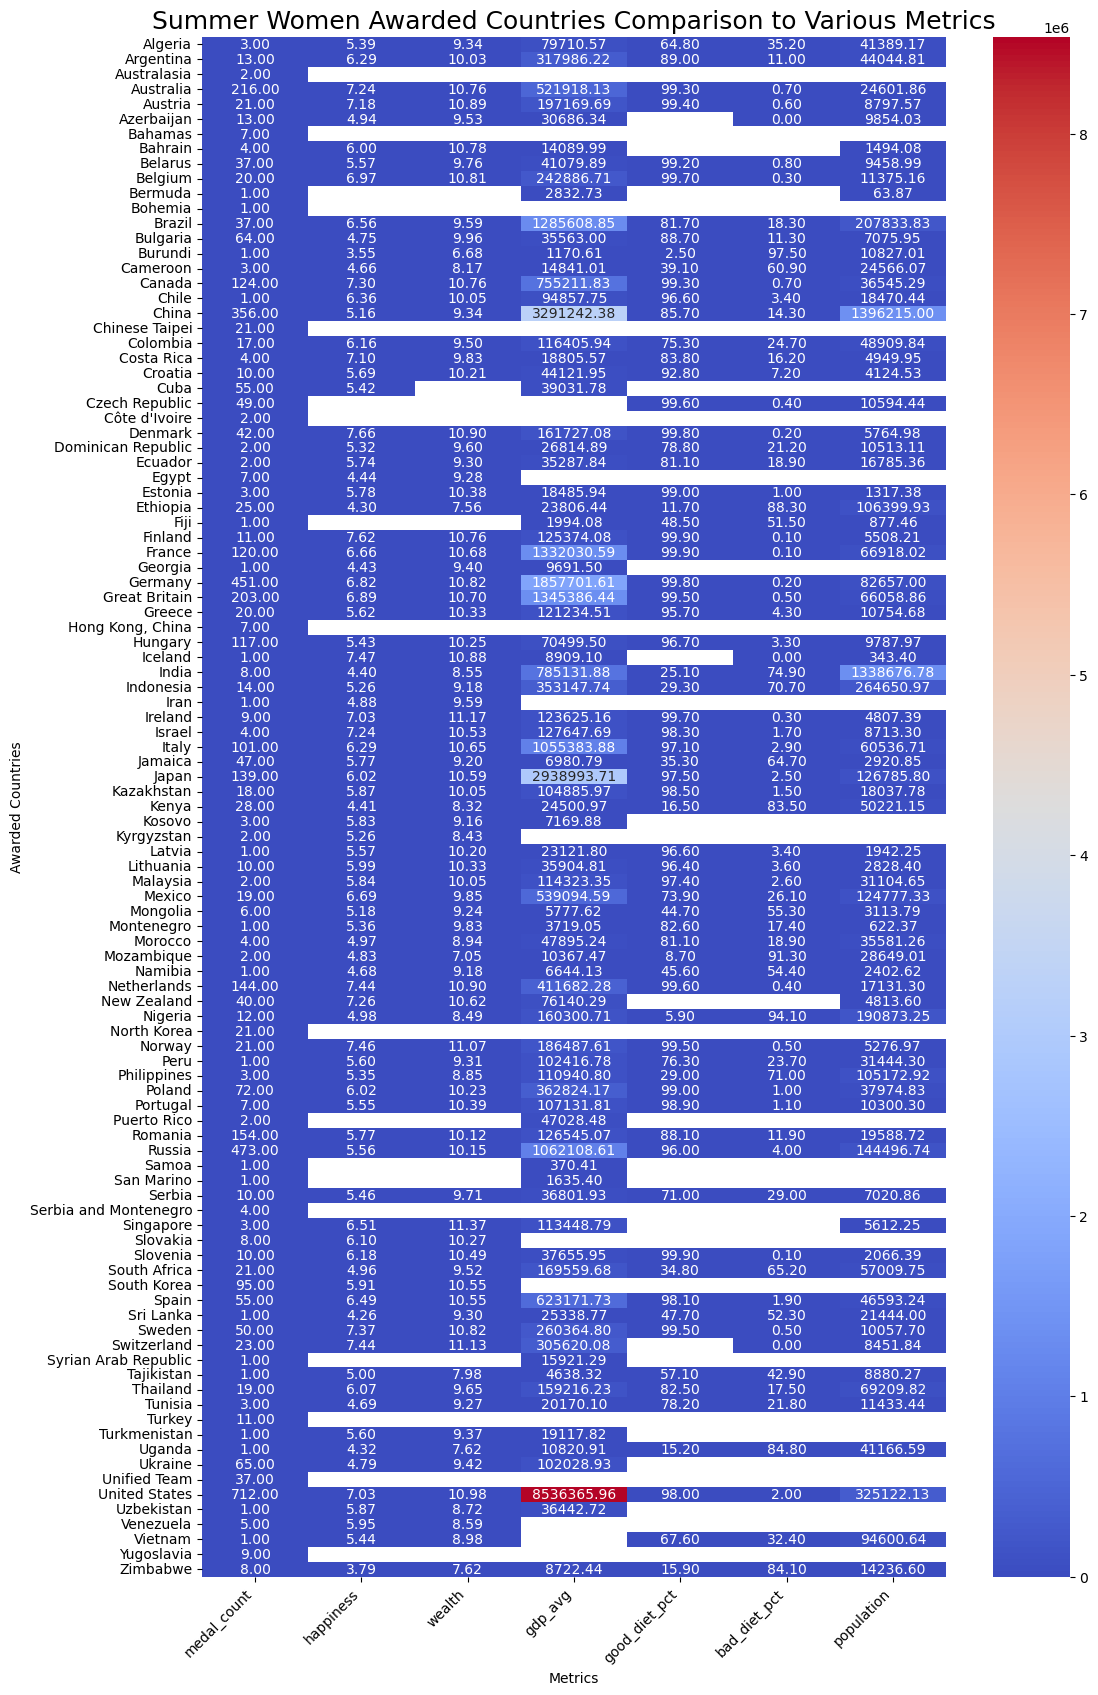

In [27]:



# Create function to update labels across heatmaps
def update_heatmap_labels(ax, new_col_labels, new_row_labels):
    ax.set_xticks(np.arange(len(new_col_labels)) + 0.5)
    ax.set_yticks(np.arange(len(new_row_labels)) + 0.5)
    ax.set_xticklabels(new_col_labels, rotation=45, ha='right')
    ax.set_yticklabels(new_row_labels, rotation=0)

# Define new column and row labels
new_col_labels = ['medal_count', 'happiness', 'wealth', 'gdp_avg', 'good_diet_pct', 'bad_diet_pct', 'population']
new_row_labels = df_country_compare_women_summer.index.tolist()

plt.figure(figsize=(12, 20))

# Create a heatmap
ax = sns.heatmap(df_country_compare_women_summer, annot=True, annot_kws={"size": 10}, cmap='coolwarm', fmt=".2f")
ax.set_xlabel("Metrics")
ax.set_ylabel("Awarded Countries")
plt.title('Summer Women Awarded Countries Comparison to Various Metrics', fontsize=18)

# Update axes to cleaner labels
update_heatmap_labels(ax, new_col_labels, new_row_labels)

# Create output
plt.show()